In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import seaborn as sb
import time
import json
import datetime as dt

from sklearn import metrics
from pandas.io.json import json_normalize
%matplotlib inline

In [2]:
train_df =  pd.read_csv('./toxicClassification/train.csv') 
train_df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [3]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test_df = pd.read_csv('./toxicClassification/test.csv')
subm_df = pd.read_csv('./toxicClassification/sample_submission.csv')

In [5]:
lens = train_df.comment_text.str.len()

In [6]:
lens.describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

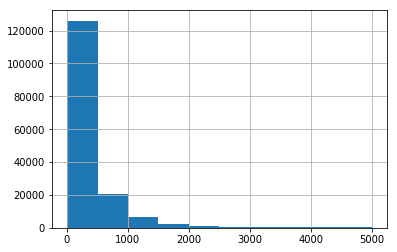

In [7]:
lens.hist()

In [8]:
print("Check for missing values in Train dataset")
null_check=train_df.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test_df.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train_df["comment_text"].fillna("unknown", inplace=True)
test_df["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


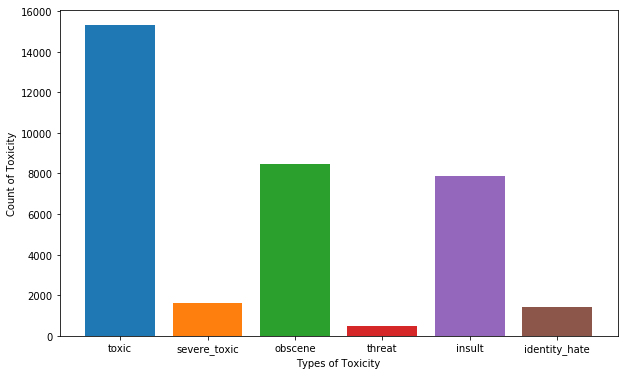

In [9]:
c1 = (train_df.toxic == 1).sum() 
c2 = (train_df.severe_toxic == 1).sum() 
c3 = (train_df.obscene == 1).sum() 
c4 = (train_df.threat == 1).sum() 
c5 = (train_df.insult == 1).sum() 
c6 = (train_df.identity_hate == 1).sum() 

plt.figure(figsize = (10,6))
plt.bar('toxic', c1)
plt.bar('severe_toxic', c2)
plt.bar('obscene', c3)
plt.bar('threat', c4)
plt.bar('insult', c5)
plt.bar('identity_hate', c6)

plt.xlabel('Types of Toxicity')
plt.ylabel('Count of Toxicity')
plt.show()

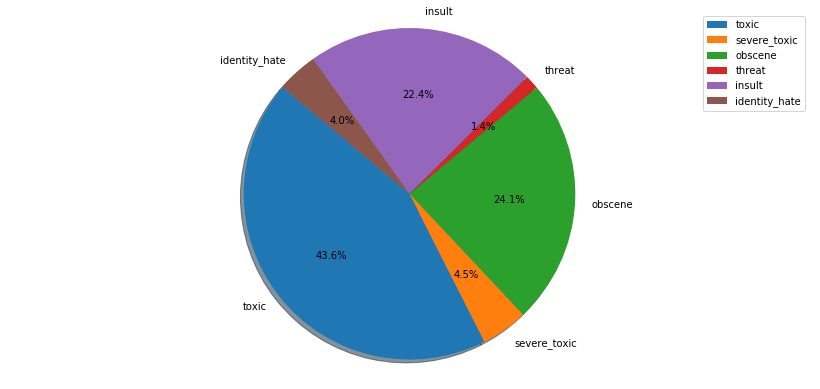

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11.5,5.5))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
sizes = [c1,c2,c3,c4,c5,c6]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)

plt.legend( labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

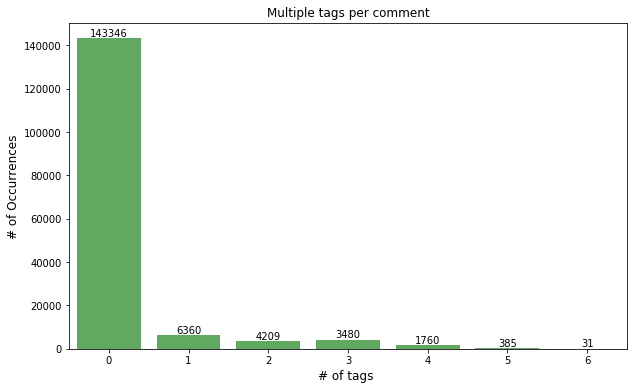

In [11]:
rowsums=train_df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
color = sb.color_palette()

#plot
plt.figure(figsize=(10,6))
ax = sb.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


In [12]:
df1 = train_df.loc[train_df['toxic'] == 1]
df2 = train_df.loc[train_df['severe_toxic'] == 1]
df3 = train_df.loc[train_df['obscene'] == 1]
df4 = train_df.loc[train_df['threat'] == 1]
df5 = train_df.loc[train_df['insult'] == 1]
df6 = train_df.loc[train_df['identity_hate'] == 1]

print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape)

(15294, 8) (1595, 8) (8449, 8) (478, 8) (7877, 8) (1405, 8)


In [13]:
x=train_df.iloc[:,2:].sum()

#marking comments without any tags as "clean"
rowsums=train_df.iloc[:,2:].sum(axis=1)
train_df['clean']=(rowsums==0)

#count number of clean entries
c7 = train_df['clean'].sum()

print("Total comments = ",len(train_df))
print("Total clean comments = ",train_df['clean'].sum())
print("Total tags =",x.sum())

df7 = train_df.loc[train_df['clean'] == True]

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [14]:
train_df.head(5)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True


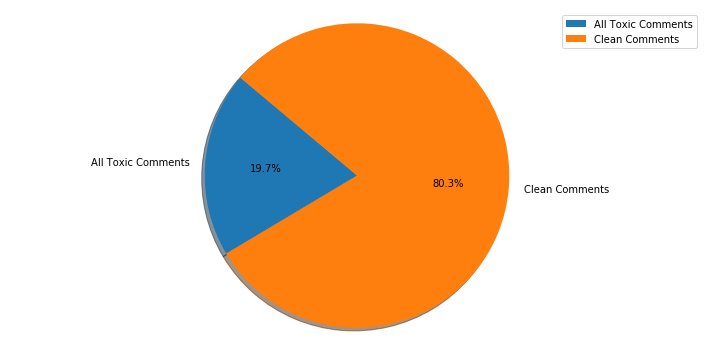

In [15]:
#Clean V/S Toxic Comments 

plt.figure(figsize=(10,5))
labels = ['All Toxic Comments', 'Clean Comments']
sizes = [ c1+c2+c3+c4+c5+c6, c7]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)

plt.legend( labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [16]:
from collections import Counter
def freq(list):
    words = Counter(list)
    frequent = words.most_common(10)
    return frequent
    

In [17]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def filter(string):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(string)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []
 
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    return filtered_sentence

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jaytorasakar8/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/jaytorasakar8/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
import re

def getFilterFreq(df):
    string1 = ""
    for row in df.itertuples(index=False):
        string1 = string1 + ' '.join(row.comment_text.lower().split())+ " "

    string1 = re.sub(r'[^\w\s]','',string1)
    string1 = filter(string1)

    list1 = freq(string1)
    print(list1)

In [19]:
df_list = [df1, df2, df3, df4, df5, df6]
for df in df_list:
    getFilterFreq(df)
    print()

[('fuck', 8613), ('shit', 3583), ('dont', 3566), ('like', 3477), ('nigger', 3289), ('wikipedia', 3260), ('fucking', 3192), ('suck', 3034), ('go', 2833), ('hate', 2614)]

[('fuck', 6048), ('suck', 2341), ('shit', 1877), ('ass', 1827), ('faggot', 1570), ('u', 1400), ('fucking', 1373), ('go', 1239), ('die', 1155), ('nigger', 1011)]

[('fuck', 8538), ('shit', 3183), ('fucking', 3097), ('suck', 2821), ('nigger', 2721), ('ass', 2517), ('go', 2117), ('u', 2056), ('dont', 1767), ('wikipedia', 1636)]

[('die', 1165), ('ass', 769), ('kill', 504), ('going', 294), ('block', 170), ('must', 166), ('jim', 158), ('wales', 157), ('supertr0ll', 149), ('dont', 145)]

[('fuck', 6620), ('nigger', 2774), ('fucking', 2710), ('suck', 2594), ('go', 2209), ('u', 1963), ('fat', 1924), ('ass', 1886), ('faggot', 1803), ('shit', 1665)]

[('nigger', 2963), ('fat', 1321), ('jew', 1307), ('gay', 911), ('die', 879), ('fuck', 875), ('faggot', 685), ('fucking', 518), ('huge', 429), ('suck', 426)]



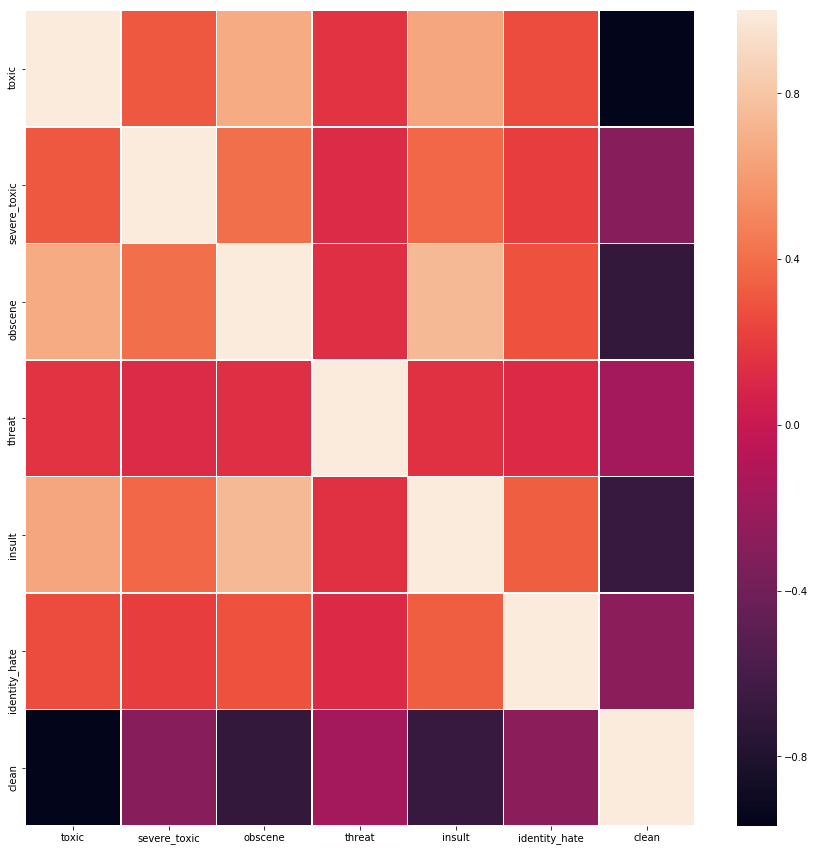

In [20]:
correlation_df = train_df[[i for i in list(train_df.columns) if i not in ['id', 'comment_text']]]
corr = correlation_df.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sb.heatmap(corr,  linewidths=.5, annot=False)
